### Get the Water Level Data

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [4]:
def process_water_data(filepath):
    # Read the file content
    with open(filepath, 'r') as file:
        data = file.read()
    
    # Split the data into rows and process
    rows = data.strip().split('\n')
    split_rows = [row.split() for row in rows]
    
    # Create DataFrame
    df = pd.DataFrame(split_rows, columns=['Agency', 'Station', 'Date', 'WaterLevel', 'Status', 'Low', 'Extra'])
    
    # Convert WaterLevel to numeric
    df['WaterLevel'] = pd.to_numeric(df['WaterLevel'], errors='coerce')
    
    # Keep only Date and WaterLevel columns
    daily_last = df[['Date', 'WaterLevel']]
    
    return daily_last

# Load and process the file
filepath = os.path.join('Data', 'Water Level 1995.csv')
Water_Level_df = process_water_data(filepath)
Water_Level_df['Date'] = pd.to_datetime(Water_Level_df['Date'])
Water_Level_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        10570 non-null  datetime64[ns]
 1   WaterLevel  6134 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 165.3 KB


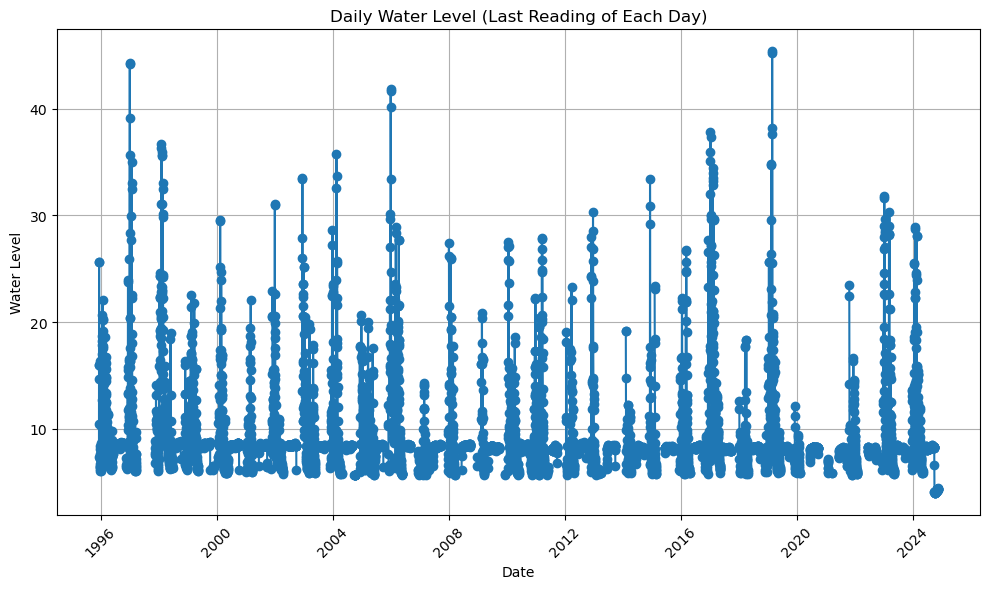

In [5]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(Water_Level_df['Date'], Water_Level_df['WaterLevel'], marker='o')
plt.title('Daily Water Level (Last Reading of Each Day)')
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Get the Rainfall Data

In [7]:
# Read the CSV data
Rain_df = pd.read_csv('Data/ven_45.csv')

In [8]:

Rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14931 entries, 0 to 14930
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE TIME  14931 non-null  object 
 1   VALUE      13897 non-null  float64
dtypes: float64(1), object(1)
memory usage: 233.4+ KB


In [9]:
Rain_df['Date'] = Rain_df['DATE TIME'].str.split().str[0]  # Keep only date part
Rain_df['Date'] = pd.to_datetime(Rain_df['Date'])
Rain_df = Rain_df.drop(columns=['DATE TIME'])
Rain_df = Rain_df.rename(columns={'VALUE': 'Precipitation'})

# Display the first few rows and basic information
print("First 5 rows:")
print(Rain_df.head())

print("\nDataset Info:")
print(Rain_df.info())

First 5 rows:
   Precipitation       Date
0            0.0 1984-01-02
1            NaN 1984-01-03
2            0.0 1984-01-04
3            0.0 1984-01-05
4            0.0 1984-01-06

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14931 entries, 0 to 14930
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Precipitation  13897 non-null  float64       
 1   Date           14931 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 233.4 KB
None


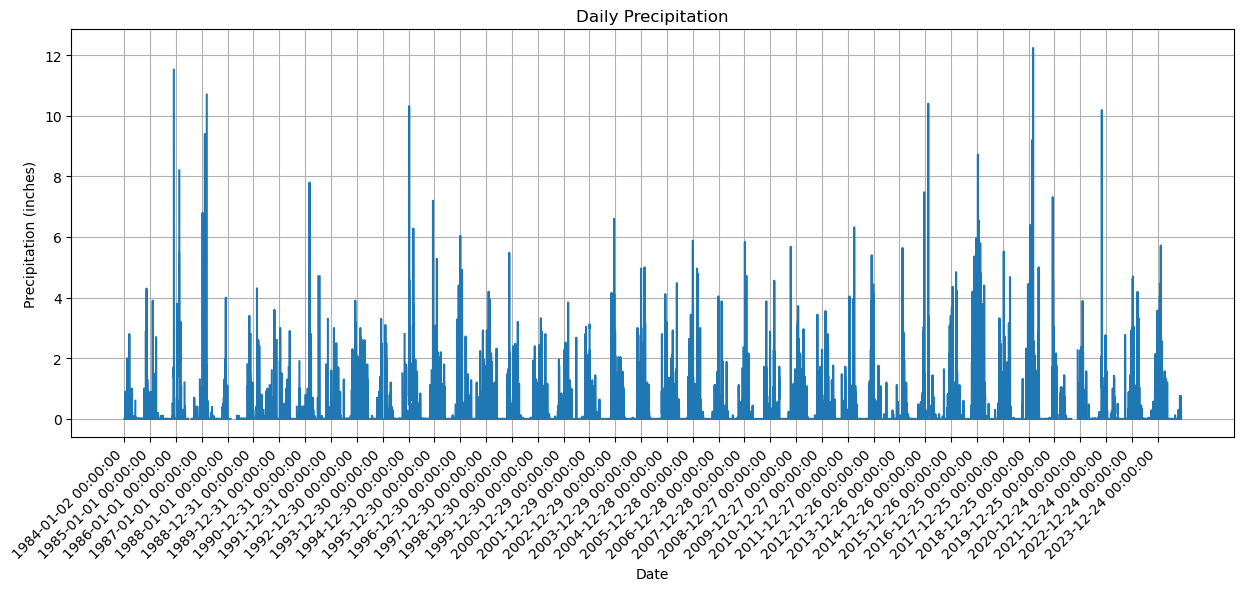

In [10]:
# Plot with fewer x-axis labels
plt.figure(figsize=(15, 6))
plt.plot(range(len(Rain_df)), Rain_df['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Daily Precipitation')

# Show labels for every 7th day
n_points = len(Rain_df)
step = 365
indices = range(0, n_points, step)
labels = Rain_df['Date'].iloc[indices]

plt.xticks(indices, labels, rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.show()

### Graph Water Level and Precipitation together

In [12]:
# Convert dates to datetime format in both dataframes
Water_Level_df['Date'] = pd.to_datetime(Water_Level_df['Date'])
Rain_df['Date'] = pd.to_datetime(Rain_df['Date'])

# Now merge the dataframes
combined_df = pd.merge(Water_Level_df, Rain_df, 
                      left_on='Date', 
                      right_on='Date',
                      how='outer')

# Sort by date
combined_df = combined_df.sort_values('Date')

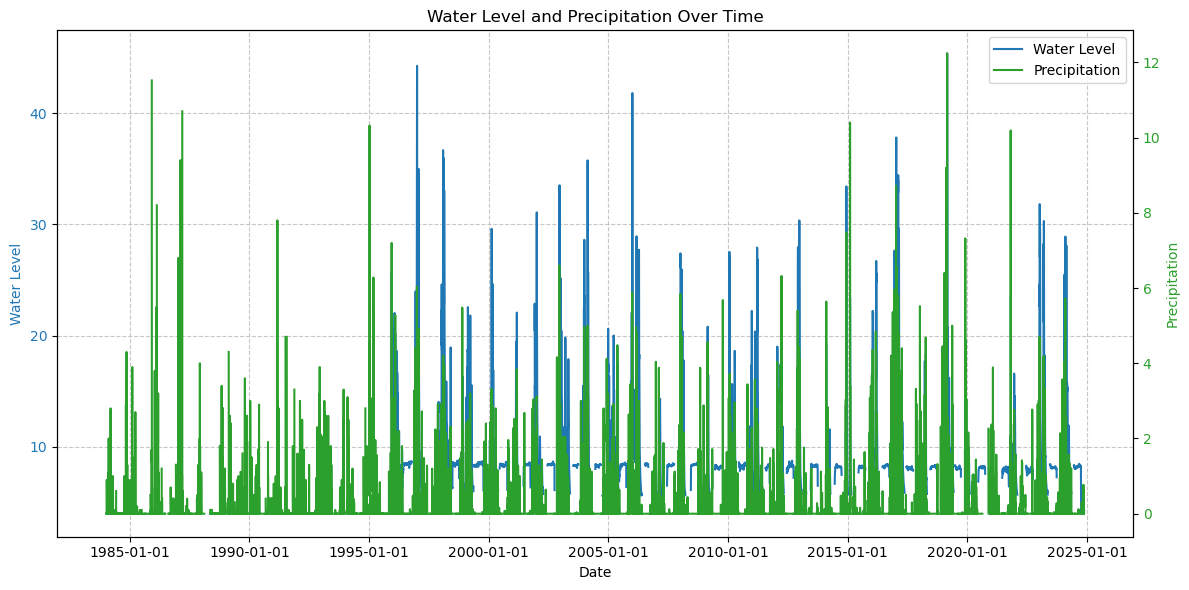

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator, DateFormatter

# Create figure and axis objects with a single subplot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot water level on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Water Level', color=color)
ax1.plot(combined_df['Date'], combined_df['WaterLevel'], color=color, label='Water Level')
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis that shares x-axis
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Precipitation', color=color)
ax2.plot(combined_df['Date'], combined_df['Precipitation'], color=color, label='Precipitation')
ax2.tick_params(axis='y', labelcolor=color)

# Set x-axis to show weekly ticks
locator = AutoDateLocator()
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

# Rotate and align the tick labels so they look better
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
ax1.grid(True, linestyle='--', alpha=0.7)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Water Level and Precipitation Over Time')
fig.tight_layout()

plt.show()


Key Findings:
1. Same-day Correlation: 0.435
2. Next-day Correlation: 0.625

Correlations by lag (days):
Lag 0 days: 0.435
Lag 1 days: 0.625
Lag 2 days: 0.618
Lag 3 days: 0.517
Lag 4 days: 0.431

Strongest relationship at lag: 1 days

Percentage of Water Level Variance Explained:
Same-day precipitation: 18.9%
Next-day precipitation: 39.1%


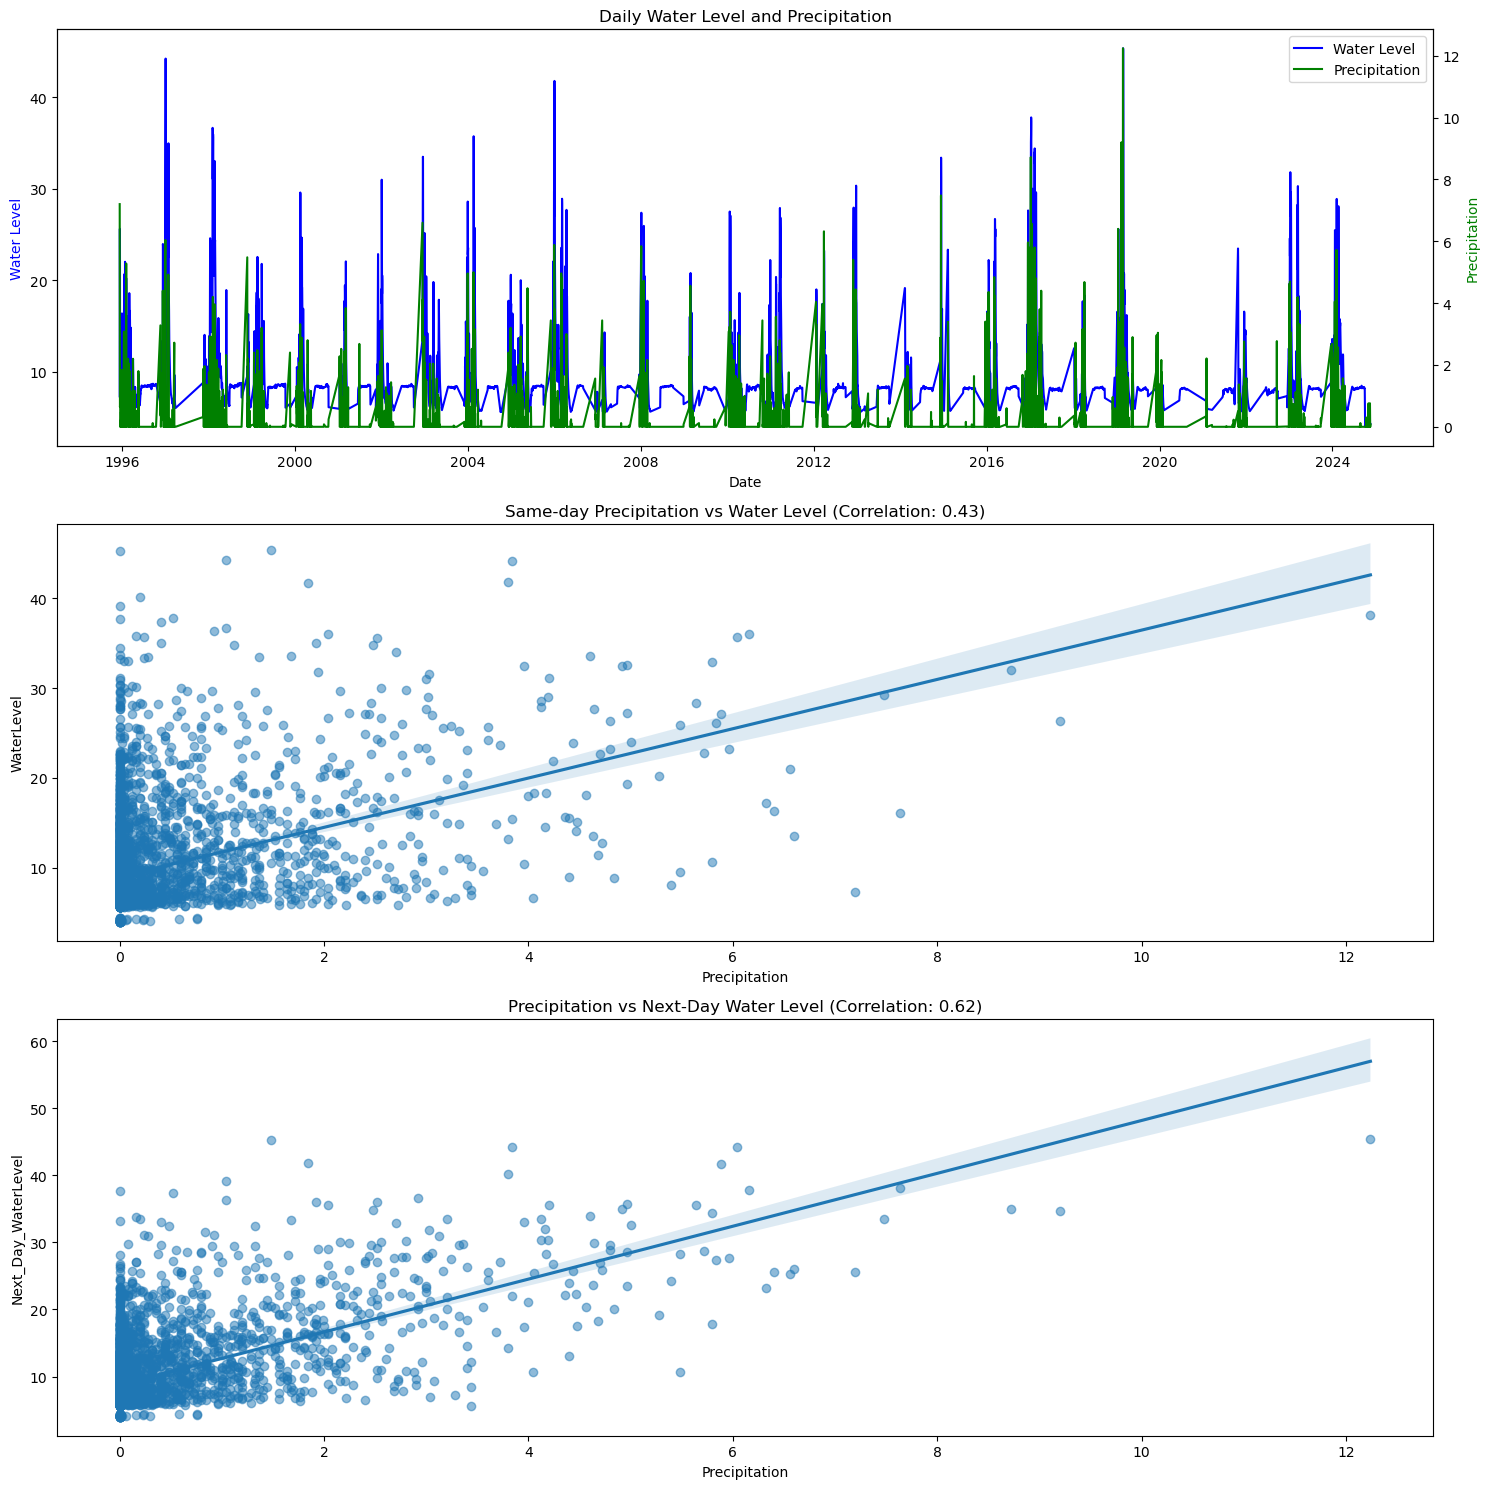

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

def analyze_precipitation_impact(water_df, rain_df):
    """
    Analyze how precipitation impacts water level with daily resolution
    """
    # Ensure dates are datetime
    combined_df = pd.merge(water_df, rain_df, 
                          left_on='Date', 
                          right_on='Date',
                          how='outer')
    combined_df = combined_df.sort_values('Date')
    
    # Handle missing values
    combined_df = combined_df.dropna()
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 15))
    
    # 1. Time Series Plot
    ax1 = plt.subplot(311)
    ax1_twin = ax1.twinx()
    
    ax1.plot(combined_df['Date'], combined_df['WaterLevel'], 
             color='blue', label='Water Level')
    ax1_twin.plot(combined_df['Date'], combined_df['Precipitation'], 
                  color='green', label='Precipitation')
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Water Level', color='blue')
    ax1_twin.set_ylabel('Precipitation', color='green')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1_twin.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.title('Daily Water Level and Precipitation')
    
    # 2. Same-day relationship
    ax2 = plt.subplot(312)
    
    # Calculate correlation
    correlation = combined_df['Precipitation'].corr(combined_df['WaterLevel'])
    
    # Create scatter plot with regression line
    sns.regplot(data=combined_df, x='Precipitation', y='WaterLevel', 
                ax=ax2, scatter_kws={'alpha':0.5})
    ax2.set_title(f'Same-day Precipitation vs Water Level (Correlation: {correlation:.2f})')
    
    # 3. Next-day Impact Analysis
    ax3 = plt.subplot(313)
    
    # Calculate next-day relationship
    combined_df['Next_Day_WaterLevel'] = combined_df['WaterLevel'].shift(-1)
    next_day_df = combined_df.dropna(subset=['Next_Day_WaterLevel'])
    next_day_corr = next_day_df['Precipitation'].corr(next_day_df['Next_Day_WaterLevel'])
    
    # Plot next-day relationship
    sns.regplot(data=next_day_df, 
                x='Precipitation', 
                y='Next_Day_WaterLevel', 
                ax=ax3, 
                scatter_kws={'alpha':0.5})
    ax3.set_title(f'Precipitation vs Next-Day Water Level (Correlation: {next_day_corr:.2f})')
    
    plt.tight_layout()
    
    # Calculate lagged correlations manually
    lag_correlations = []
    for lag in range(5):  # Calculate for 0 to 4 days lag
        lagged_water = combined_df['WaterLevel'].shift(-lag)
        lag_corr = combined_df['Precipitation'].corr(lagged_water)
        lag_correlations.append(lag_corr)
    
    # Calculate and return key statistics
    stats_dict = {
        'same_day_correlation': correlation,
        'next_day_correlation': next_day_corr,
        'lag_correlations': lag_correlations,
        'lag_at_max_correlation': np.argmax(lag_correlations)
    }
    
    return stats_dict

# Run the analysis
stats = analyze_precipitation_impact(Water_Level_df, Rain_df)

# Print key findings
print("\nKey Findings:")
print(f"1. Same-day Correlation: {stats['same_day_correlation']:.3f}")
print(f"2. Next-day Correlation: {stats['next_day_correlation']:.3f}")
print("\nCorrelations by lag (days):")
for i, corr in enumerate(stats['lag_correlations']):
    print(f"Lag {i} days: {corr:.3f}")
print(f"\nStrongest relationship at lag: {stats['lag_at_max_correlation']} days")

# Calculate percentage of variance explained
print(f"\nPercentage of Water Level Variance Explained:")
print(f"Same-day precipitation: {(stats['same_day_correlation']**2 * 100):.1f}%")
print(f"Next-day precipitation: {(stats['next_day_correlation']**2 * 100):.1f}%")


ARMA Model Results:
                               SARIMAX Results                                
Dep. Variable:             WaterLevel   No. Observations:                10571
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -17899.162
Date:                Mon, 18 Nov 2024   AIC                          35808.323
Time:                        15:50:56   BIC                          35844.652
Sample:                    12-11-1995   HQIC                         35820.586
                         - 11-18-2024                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.3452      0.310     26.919      0.000       7.738       8.953
Precipitation    -0.1197      0.004    -32.608      0.000      -0.127      -0.113
ar.L1             0

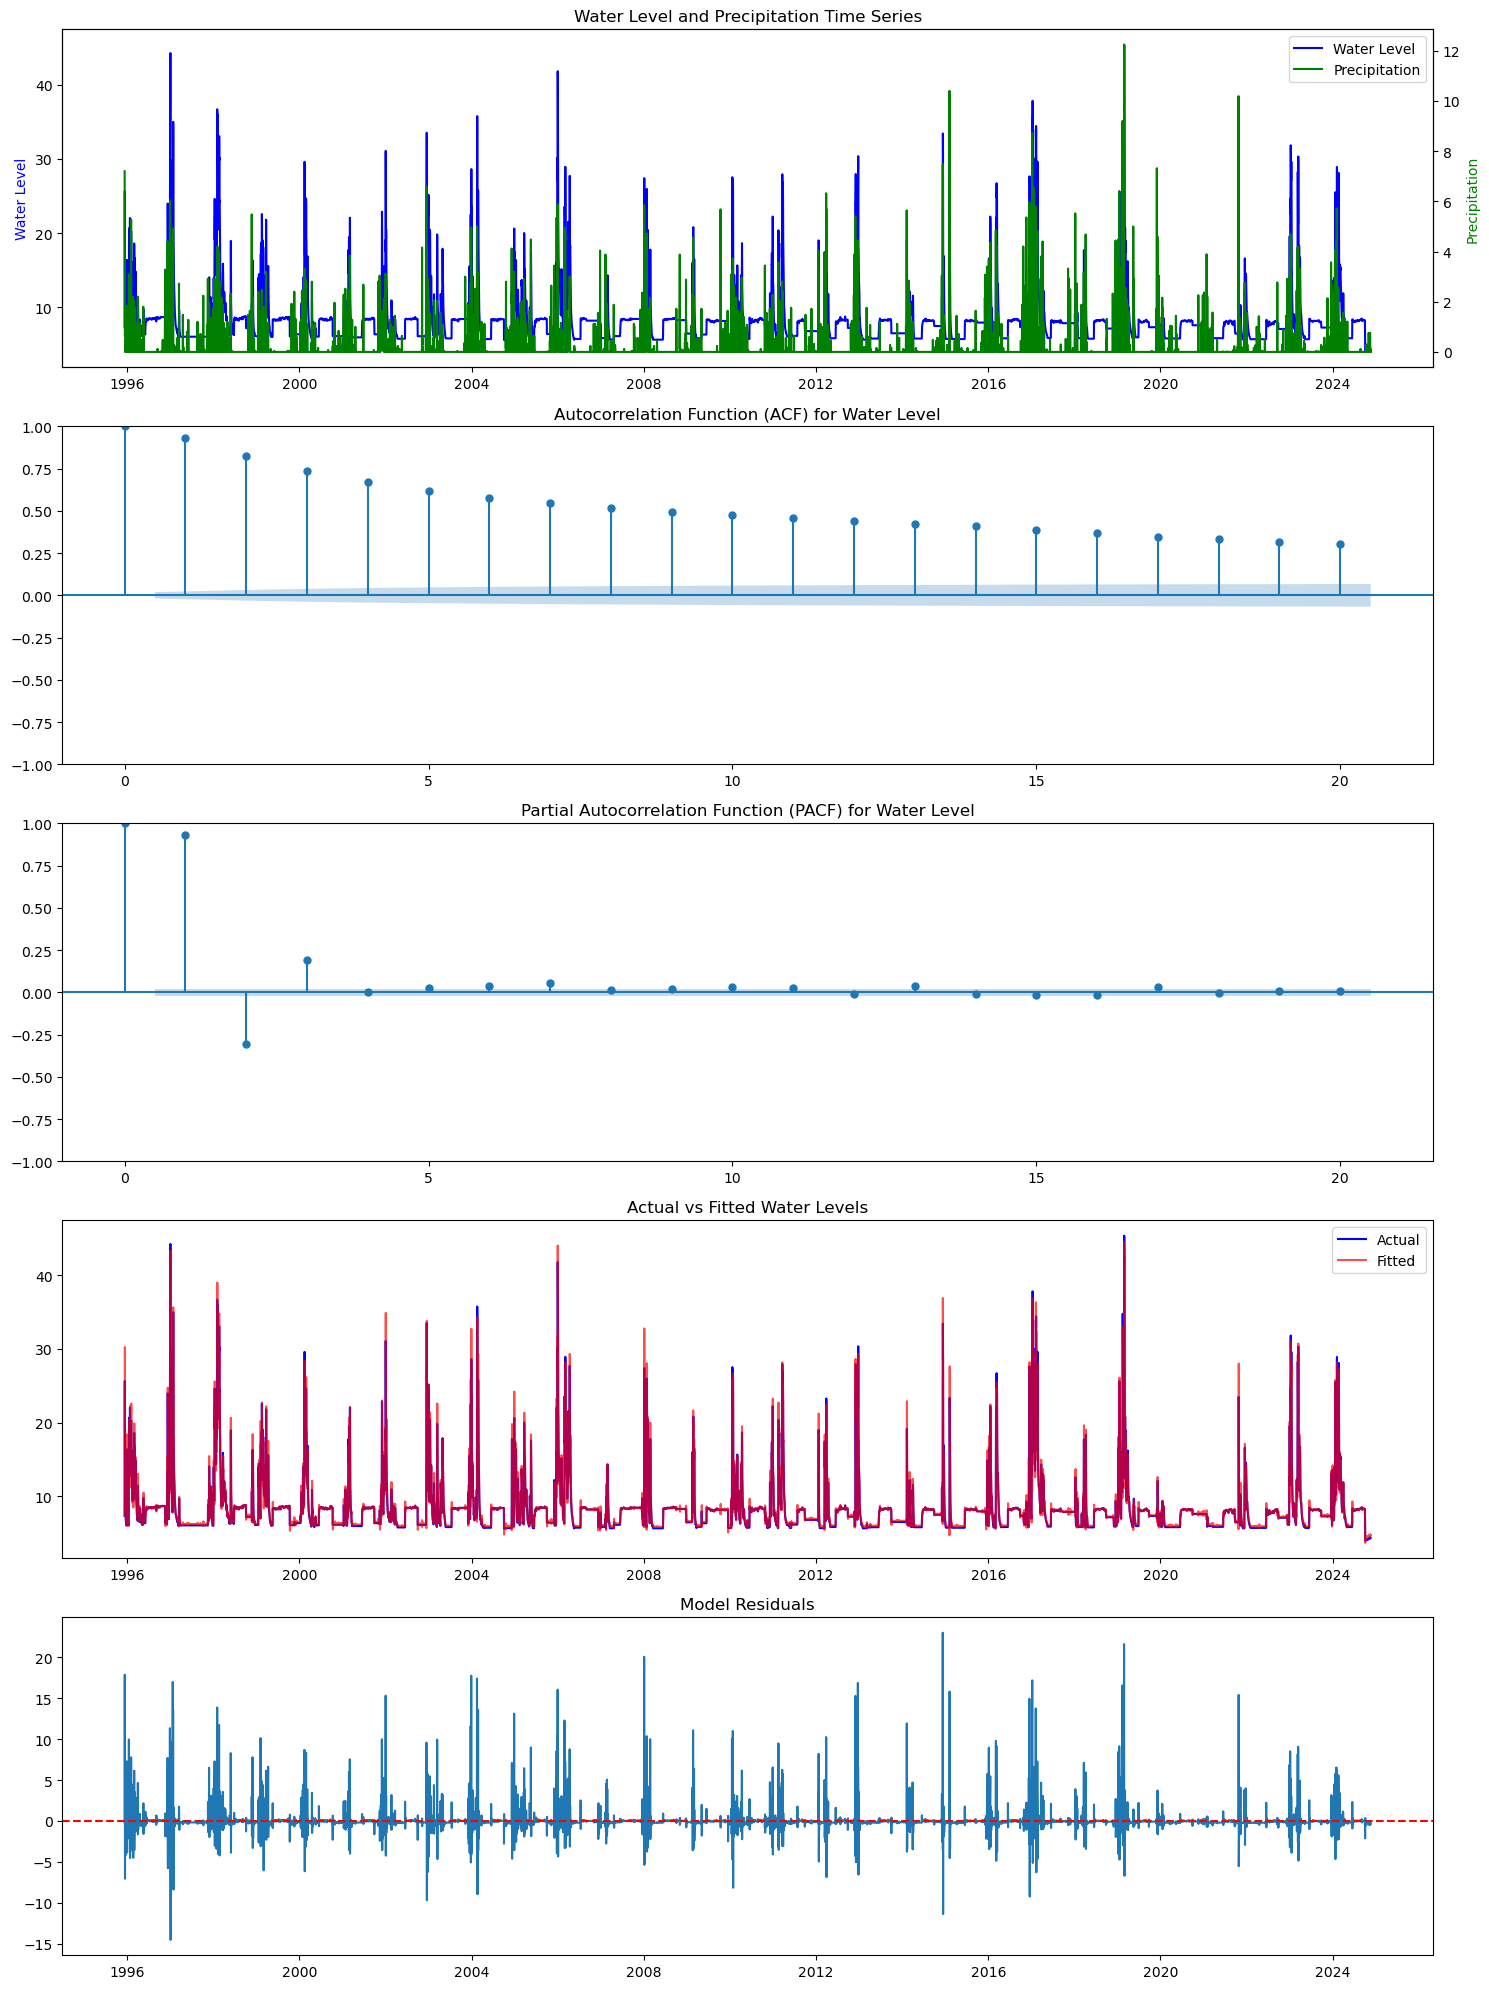

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

def perform_arma_analysis(water_df, rain_df):
    """
    Analyze water level and precipitation relationship using ARMA modeling
    """
    # Merge and prepare data
    combined_df = pd.merge(water_df, rain_df, 
                          left_on='Date', 
                          right_on='Date',
                          how='outer')
    
    # Convert Date to datetime if it isn't already
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])
    
    # Sort and handle missing values before setting index
    combined_df = combined_df.sort_values('Date')
    
    # Forward fill missing values using recommended methods
    combined_df['WaterLevel'] = combined_df['WaterLevel'].ffill()
    combined_df['Precipitation'] = combined_df['Precipitation'].fillna(0)
    
    # Remove any remaining NaN values
    combined_df = combined_df.dropna()
    
    # Set Date as index with frequency
    combined_df.set_index('Date', inplace=True)
    
    # Infer and set the frequency
    if combined_df.index.inferred_freq:
        combined_df = combined_df.asfreq(combined_df.index.inferred_freq)
    else:
        # If frequency cannot be inferred, check for daily data
        median_diff = np.median(np.diff(combined_df.index.astype(np.int64)) / 1e9 / 86400)
        if 0.8 < median_diff < 1.2:  # If median difference is around 1 day
            combined_df = combined_df.asfreq('D')
        else:
            print("Warning: Could not determine data frequency. Please ensure data is sampled at regular intervals.")
    
    # Fill any new NaNs created by frequency setting
    combined_df['WaterLevel'] = combined_df['WaterLevel'].ffill()
    combined_df['Precipitation'] = combined_df['Precipitation'].fillna(0)
    
    # Verify no infinities
    combined_df = combined_df.replace([np.inf, -np.inf], np.nan)
    combined_df = combined_df.dropna()
    
    # Create figure for analysis plots
    fig = plt.figure(figsize=(15, 20))
    
    # 1. Original Time Series
    ax1 = plt.subplot(511)
    ax1_twin = ax1.twinx()
    
    ax1.plot(combined_df.index, combined_df['WaterLevel'], 
             color='blue', label='Water Level')
    ax1_twin.plot(combined_df.index, combined_df['Precipitation'], 
                  color='green', label='Precipitation')
    
    ax1.set_ylabel('Water Level', color='blue')
    ax1_twin.set_ylabel('Precipitation', color='green')
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1_twin.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    plt.title('Water Level and Precipitation Time Series')
    
    # 2. ACF and PACF for Water Level
    ax2 = plt.subplot(512)
    plot_acf(combined_df['WaterLevel'], lags=20, ax=ax2)
    ax2.set_title('Autocorrelation Function (ACF) for Water Level')
    
    ax3 = plt.subplot(513)
    plot_pacf(combined_df['WaterLevel'], lags=20, ax=ax3)
    ax3.set_title('Partial Autocorrelation Function (PACF) for Water Level')
    
    # Fit ARIMA model
    # Start with ARIMA(1,0,1) with exogenous variable (precipitation)
    model = ARIMA(combined_df['WaterLevel'],
                  exog=combined_df['Precipitation'],
                  order=(1,0,1))
    results = model.fit()
    
    # 4. Plot actual vs fitted values
    ax4 = plt.subplot(514)
    ax4.plot(combined_df.index, combined_df['WaterLevel'], 
             label='Actual', color='blue')
    ax4.plot(combined_df.index, results.fittedvalues, 
             label='Fitted', color='red', alpha=0.7)
    ax4.set_title('Actual vs Fitted Water Levels')
    ax4.legend()
    
    # 5. Plot residuals
    ax5 = plt.subplot(515)
    residuals = results.resid
    ax5.plot(combined_df.index, residuals)
    ax5.axhline(y=0, color='r', linestyle='--')
    ax5.set_title('Model Residuals')
    
    plt.tight_layout()
    
    # Perform Augmented Dickey-Fuller test
    adf_result = adfuller(combined_df['WaterLevel'])
    
    # Calculate model metrics
    mse = np.mean(residuals**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(residuals))
    
    # Store statistics
    stats_dict = {
        'aic': results.aic,
        'bic': results.bic,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'params': results.params,
        'pvalues': results.pvalues,
        'adf_pvalue': adf_result[1]
    }
    
    return results, stats_dict, combined_df

# Run the analysis
model_results, stats, combined_df = perform_arma_analysis(Water_Level_df, Rain_df)

# Print detailed results
print("\nARMA Model Results:")
print(model_results.summary())

print("\nModel Performance Metrics:")
print(f"AIC: {stats['aic']:.2f}")
print(f"BIC: {stats['bic']:.2f}")
print(f"RMSE: {stats['rmse']:.2f}")
print(f"MAE: {stats['mae']:.2f}")

print("\nModel Parameters:")
for param, value in stats['params'].items():
    print(f"{param}: {value:.4f} (p-value: {stats['pvalues'][param]:.4f})")

print("\nStationarity Test:")
print(f"ADF p-value: {stats['adf_pvalue']:.4f}")
print("Null hypothesis of non-stationarity is", 
      "rejected" if stats['adf_pvalue'] < 0.05 else "not rejected",
      "at 5% significance level")

# Calculate R-squared properly
actuals = combined_df['WaterLevel']
predictions = model_results.fittedvalues
residuals = actuals - predictions
ss_res = (residuals ** 2).sum()
ss_tot = ((actuals - actuals.mean()) ** 2).sum()
r2 = 1 - (ss_res / ss_tot)

print(f"\nR-squared: {r2:.4f}")

### Water Level drop with no precipitation


Overall Water Level Drop Statistics (No Precipitation):
Number of dry days analyzed: 4550

Average daily drop: 0.252 ft
Median daily drop: 0.020 ft
Standard deviation: 0.893 ft
Minimum drop: -5.810 ft
Maximum drop: 18.720 ft

Statistics by Water Level Range (all values in feet):
            Level_Drop                            WaterLevel
                 count   mean    std   min    max       mean
Level_Range                                                 
4.0-7.5ft          911  0.102  0.292 -4.29   2.56      6.481
7.5-8.2ft          921  0.057  0.228 -2.63   1.57      7.995
8.2-8.3ft          940  0.020  0.156 -1.80   1.86      8.269
8.3-8.5ft          886  0.020  0.121 -0.26   1.65      8.434
8.5-45.2ft         892  1.081  1.739 -5.81  18.72     12.168

Correlation between water level and drop rate: 0.741

Drop Rates as Percentage of Initial Level:
Average drop percentage: 1.96%
Median drop percentage: 0.25%


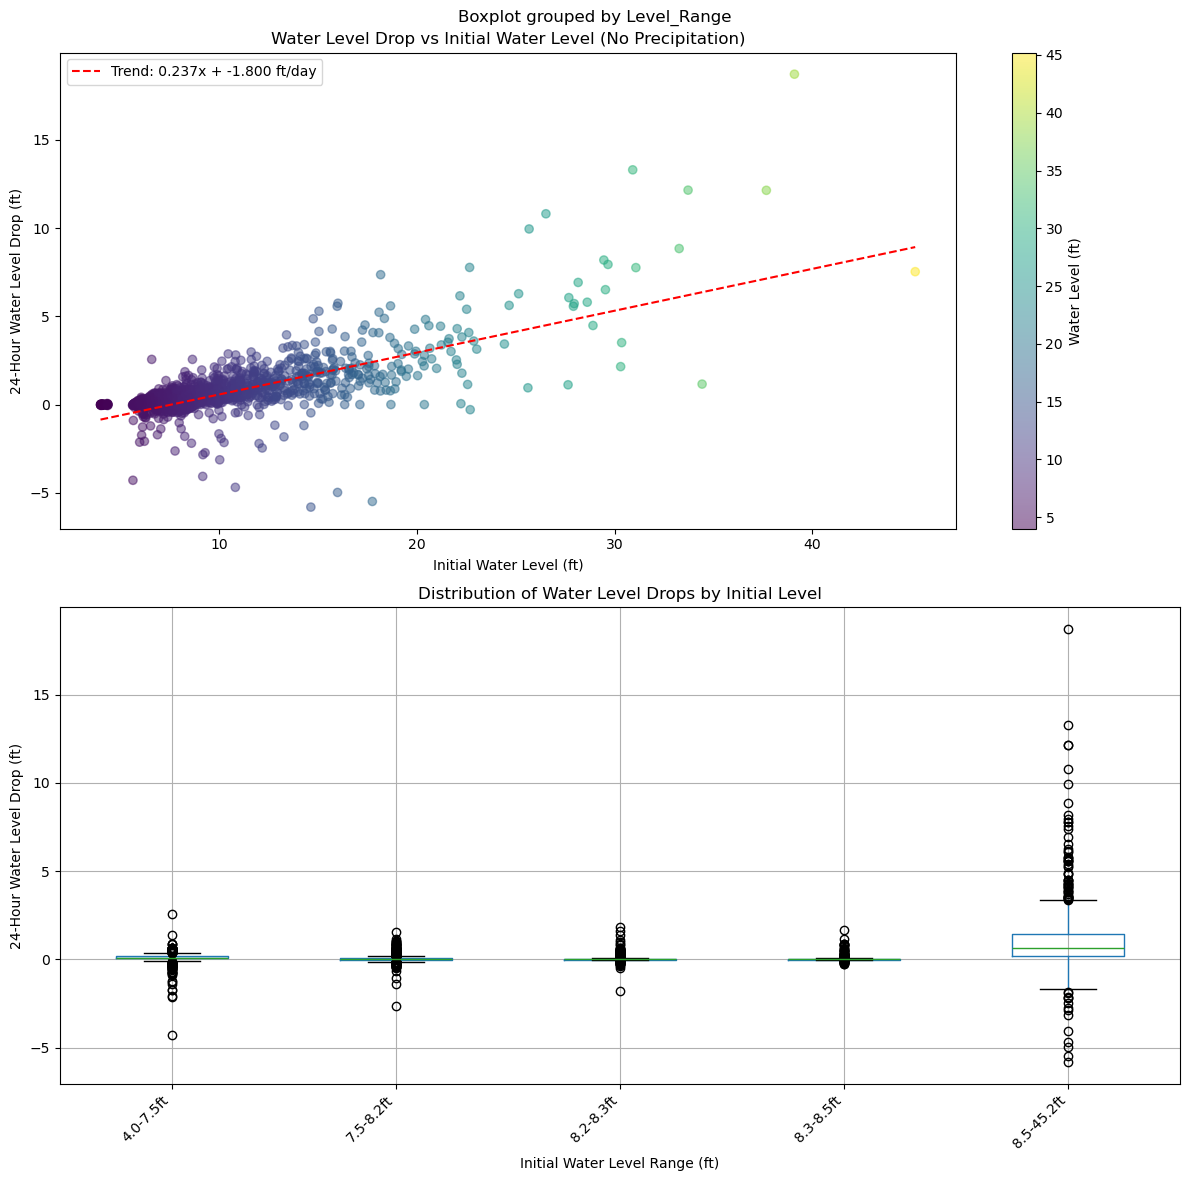

In [17]:
def analyze_water_level_drop(water_df, rain_df):
    """
    Analyze how water level drops over 24 hours when there's no precipitation
    """
    # Merge and prepare data
    combined_df = pd.merge(water_df, rain_df, 
                          left_on='Date', 
                          right_on='Date',
                          how='inner')  # Changed to inner join to ensure matching dates
    
    # Convert Date to datetime if it isn't already
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])
    combined_df = combined_df.sort_values('Date')
    
    # Calculate next day's water level and drop
    combined_df['Next_Day_Level'] = combined_df['WaterLevel'].shift(-1)
    combined_df['Level_Drop'] = combined_df['WaterLevel'] - combined_df['Next_Day_Level']
    
    # Filter for days with no precipitation
    dry_days = combined_df[combined_df['Precipitation'] == 0].copy()
    dry_days = dry_days.dropna(subset=['WaterLevel', 'Level_Drop'])
    
    # Create 5 bins based on water level ranges
    bin_edges = np.percentile(dry_days['WaterLevel'], [0, 20, 40, 60, 80, 100])
    bin_labels = [f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}ft' for i in range(len(bin_edges)-1)]
    dry_days['Level_Range'] = pd.cut(dry_days['WaterLevel'], 
                                    bins=bin_edges, 
                                    labels=bin_labels,
                                    include_lowest=True)
    
    # Calculate statistics by water level range
    drops_by_level = dry_days.groupby('Level_Range', observed=True).agg({
        'Level_Drop': ['count', 'mean', 'std', 'min', 'max'],
        'WaterLevel': ['mean']
    }).round(3)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Scatter plot
    scatter = ax1.scatter(dry_days['WaterLevel'], 
                         dry_days['Level_Drop'],
                         alpha=0.5, 
                         c=dry_days['WaterLevel'],  # Color by water level
                         cmap='viridis')
    ax1.set_xlabel('Initial Water Level (ft)')
    ax1.set_ylabel('24-Hour Water Level Drop (ft)')
    ax1.set_title('Water Level Drop vs Initial Water Level (No Precipitation)')
    
    # Add trend line
    z = np.polyfit(dry_days['WaterLevel'], dry_days['Level_Drop'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(dry_days['WaterLevel'].min(), dry_days['WaterLevel'].max(), 100)
    ax1.plot(x_range, p(x_range), "r--", 
             label=f'Trend: {z[0]:.3f}x + {z[1]:.3f} ft/day')
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax1, label='Water Level (ft)')
    ax1.legend()
    
    # Box plot
    dry_days.boxplot(column='Level_Drop', 
                     by='Level_Range', 
                     ax=ax2,
                     whis=1.5)  # 1.5 IQR for whiskers
    ax2.set_xlabel('Initial Water Level Range (ft)')
    ax2.set_ylabel('24-Hour Water Level Drop (ft)')
    ax2.set_title('Distribution of Water Level Drops by Initial Level')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    return drops_by_level, dry_days

# Run analysis
level_stats, dry_period_data = analyze_water_level_drop(Water_Level_df, Rain_df)

# Print overall statistics
print("\nOverall Water Level Drop Statistics (No Precipitation):")
print(f"Number of dry days analyzed: {len(dry_period_data)}")
print(f"\nAverage daily drop: {dry_period_data['Level_Drop'].mean():.3f} ft")
print(f"Median daily drop: {dry_period_data['Level_Drop'].median():.3f} ft")
print(f"Standard deviation: {dry_period_data['Level_Drop'].std():.3f} ft")
print(f"Minimum drop: {dry_period_data['Level_Drop'].min():.3f} ft")
print(f"Maximum drop: {dry_period_data['Level_Drop'].max():.3f} ft")

# Print statistics by water level range
print("\nStatistics by Water Level Range (all values in feet):")
print(level_stats)

# Calculate correlation
correlation = dry_period_data['WaterLevel'].corr(dry_period_data['Level_Drop'])
print(f"\nCorrelation between water level and drop rate: {correlation:.3f}")

# Print drop rates as percentages
print("\nDrop Rates as Percentage of Initial Level:")
dry_period_data['Drop_Percentage'] = (dry_period_data['Level_Drop'] / dry_period_data['WaterLevel']) * 100
print(f"Average drop percentage: {dry_period_data['Drop_Percentage'].mean():.2f}%")
print(f"Median drop percentage: {dry_period_data['Drop_Percentage'].median():.2f}%")


Prediction Statistics:
RMSE: 1.809 ft
Maximum Rise: 22.650 ft
Maximum Drop: -18.720 ft

Relationship Analysis:

Correlation Matrix:
                WaterLevel  Precipitation  Next_Day_Level
WaterLevel           1.000          0.436           0.922
Precipitation        0.436          1.000           0.631
Next_Day_Level       0.922          0.631           1.000

Average Effects:

Average level change by precipitation quintile:
Precipitation
(-0.001, 0.08]   -0.281808
(0.08, 12.24]     1.013903
Name: Level_Change, dtype: float64

Average level change by current water level quintile:
WaterLevel
(3.999, 7.44]    0.161774
(7.44, 8.21]     0.039080
(8.21, 8.42]    -0.012221
(8.42, 10.4]     0.077421
(10.4, 45.38]   -0.478230
Name: Level_Change, dtype: float64


C:\Users\micro\AppData\Local\Temp\ipykernel_22468\1075039240.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rain_effect = prediction_data.groupby(pd.qcut(prediction_data['Precipitation'],
C:\Users\micro\AppData\Local\Temp\ipykernel_22468\1075039240.py:103: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  level_effect = prediction_data.groupby(pd.qcut(prediction_data['WaterLevel'],


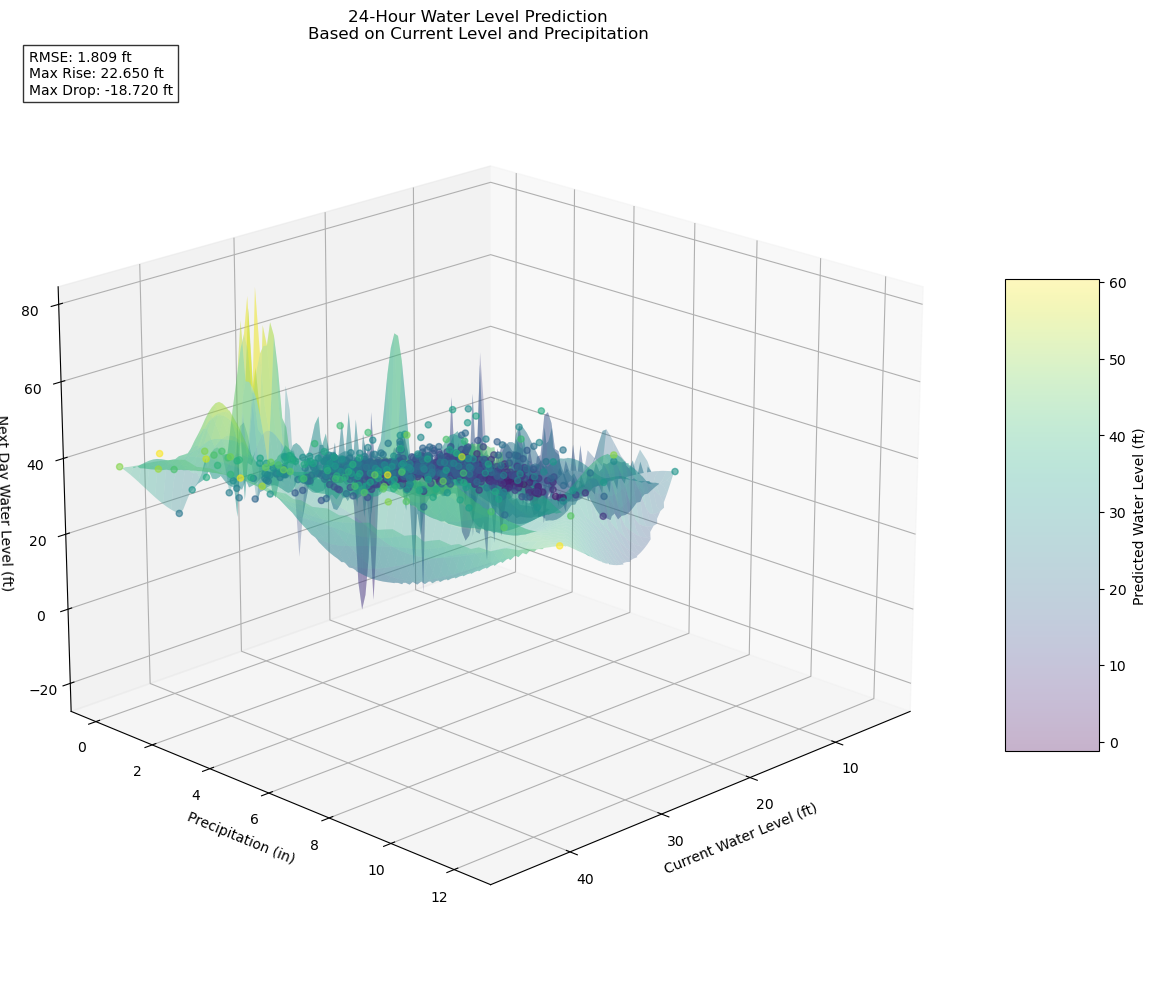

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

def create_3d_water_prediction():
    # Merge the dataframes
    combined_df = pd.merge(Water_Level_df, Rain_df, 
                          on='Date', 
                          how='inner')
    
    # Calculate next day's water level
    combined_df['Next_Day_Level'] = combined_df['WaterLevel'].shift(-1)
    
    # Remove any rows with NaN
    combined_df = combined_df.dropna()
    
    # Create figure
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract data points
    x = combined_df['WaterLevel'].values
    y = combined_df['Precipitation'].values
    z = combined_df['Next_Day_Level'].values
    
    # Create a regular grid to interpolate the data
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate for smooth surface
    zi = griddata((x, y), z, (xi, yi), method='cubic')
    
    # Create the 3D plot
    # Scatter plot of actual data
    scatter = ax.scatter(x, y, z, 
                        c=z, 
                        cmap='viridis',
                        label='Actual Data',
                        alpha=0.6)
    
    # Surface plot of interpolated predictions
    surface = ax.plot_surface(xi, yi, zi,
                            cmap='viridis',
                            alpha=0.3,
                            shade=True)
    
    # Customize the plot
    ax.set_xlabel('Current Water Level (ft)')
    ax.set_ylabel('Precipitation (in)')
    ax.set_zlabel('Next Day Water Level (ft)')
    ax.set_title('24-Hour Water Level Prediction\nBased on Current Level and Precipitation')
    
    # Add colorbar
    fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5, label='Predicted Water Level (ft)')
    
    # Adjust the view
    ax.view_init(elev=20, azim=45)
    
    # Calculate some statistics
    rmse = np.sqrt(np.mean((combined_df['Next_Day_Level'] - combined_df['WaterLevel'])**2))
    max_rise = np.max(combined_df['Next_Day_Level'] - combined_df['WaterLevel'])
    max_drop = np.min(combined_df['Next_Day_Level'] - combined_df['WaterLevel'])
    
    print("\nPrediction Statistics:")
    print(f"RMSE: {rmse:.3f} ft")
    print(f"Maximum Rise: {max_rise:.3f} ft")
    print(f"Maximum Drop: {max_drop:.3f} ft")
    
    # Add text box with key statistics
    stats_text = (f'RMSE: {rmse:.3f} ft\n'
                 f'Max Rise: {max_rise:.3f} ft\n'
                 f'Max Drop: {max_drop:.3f} ft')
    ax.text2D(0.02, 0.95, stats_text, 
              transform=ax.transAxes,
              bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig, combined_df

# Create the plot and get the data
fig, prediction_data = create_3d_water_prediction()

# Additional analysis of the relationship
print("\nRelationship Analysis:")
print("\nCorrelation Matrix:")
correlation_matrix = prediction_data[['WaterLevel', 'Precipitation', 'Next_Day_Level']].corr()
print(correlation_matrix.round(3))

# Calculate average effects
print("\nAverage Effects:")
# Effect of precipitation on water level change
prediction_data['Level_Change'] = prediction_data['Next_Day_Level'] - prediction_data['WaterLevel']
rain_effect = prediction_data.groupby(pd.qcut(prediction_data['Precipitation'], 
                                            q=5, 
                                            duplicates='drop'))['Level_Change'].mean()
print("\nAverage level change by precipitation quintile:")
print(rain_effect)

# Effect of current level on change
level_effect = prediction_data.groupby(pd.qcut(prediction_data['WaterLevel'], 
                                             q=5, 
                                             duplicates='drop'))['Level_Change'].mean()
print("\nAverage level change by current water level quintile:")
print(level_effect)

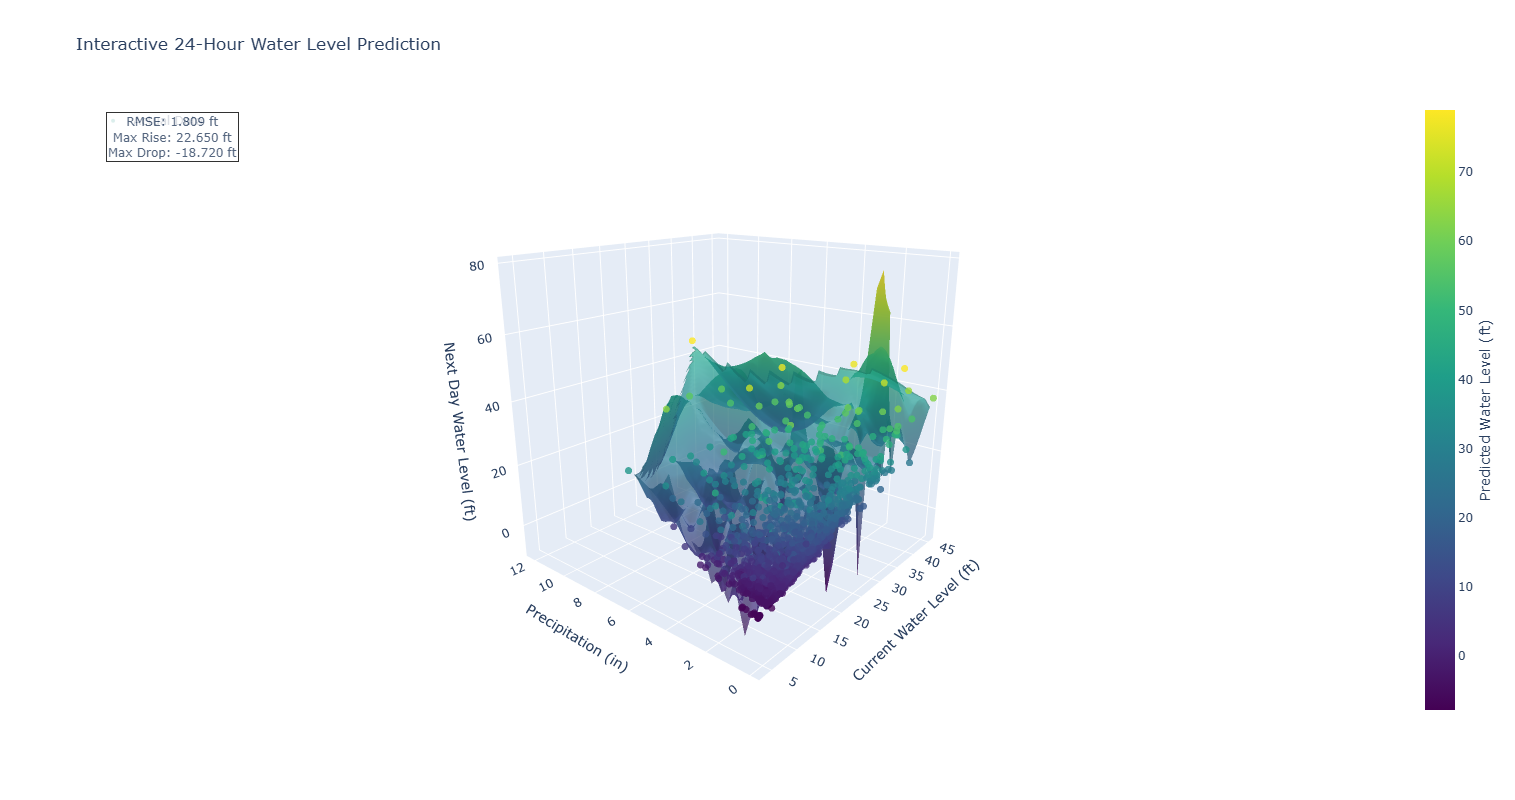


Relationship Analysis:

Correlation Matrix:
                WaterLevel  Precipitation  Next_Day_Level
WaterLevel           1.000          0.436           0.922
Precipitation        0.436          1.000           0.631
Next_Day_Level       0.922          0.631           1.000

Water Level Change by Precipitation (ft):
               count   mean    std
Rain_Category                     
No Rain         4550 -0.252  0.893
Light            284 -0.756  1.759
Moderate         424 -0.388  2.437
Heavy            243  0.504  2.651
Very Heavy       410  2.802  4.086

Water Level Change by Current Level (ft):
                count   mean    std
Level_Category                     
Very Low          684  0.141  1.347
Low               887  0.135  1.458
Normal            585  0.044  0.838
High             2129 -0.003  0.470
Very High        1625 -0.301  3.055

Key Insights:
1. Precipitation Effects:
  - No rain causes average drop of -0.252 ft
  - Very heavy rain causes average rise of 2.802 ft
  

In [19]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

def create_interactive_3d_prediction():
    # Merge the dataframes
    combined_df = pd.merge(Water_Level_df, Rain_df, 
                          on='Date', 
                          how='inner')
    
    # Calculate next day's water level
    combined_df['Next_Day_Level'] = combined_df['WaterLevel'].shift(-1)
    
    # Remove any rows with NaN
    combined_df = combined_df.dropna()
    
    # Extract data points
    x = combined_df['WaterLevel'].values
    y = combined_df['Precipitation'].values
    z = combined_df['Next_Day_Level'].values
    
    # Create a regular grid to interpolate the data
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate for smooth surface
    zi = griddata((x, y), z, (xi, yi), method='cubic')
    
    # Create the figure
    fig = go.Figure()
    
    # Add surface plot
    fig.add_trace(go.Surface(
        x=xi,
        y=yi,
        z=zi,
        opacity=0.7,
        colorscale='Viridis',
        name='Predicted Level',
        showscale=True,
        colorbar=dict(
            title='Predicted Water Level (ft)',
            titleside='right'
        )
    ))
    
    # Add scatter points
    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=4,
            color=z,
            colorscale='Viridis',
            opacity=0.8
        ),
        text=[f'Date: {d}<br>Current Level: {cl:.2f} ft<br>Rain: {p:.2f} in<br>Next Day: {nl:.2f} ft' 
              for d, cl, p, nl in zip(combined_df['Date'], 
                                    combined_df['WaterLevel'],
                                    combined_df['Precipitation'],
                                    combined_df['Next_Day_Level'])],
        hoverinfo='text',
        name='Actual Data'
    ))
    
    # Update layout
    fig.update_layout(
        title='Interactive 24-Hour Water Level Prediction',
        scene=dict(
            xaxis_title='Current Water Level (ft)',
            yaxis_title='Precipitation (in)',
            zaxis_title='Next Day Water Level (ft)',
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=1000,
        height=800,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    # Calculate statistics for annotation
    rmse = np.sqrt(np.mean((combined_df['Next_Day_Level'] - combined_df['WaterLevel'])**2))
    max_rise = np.max(combined_df['Next_Day_Level'] - combined_df['WaterLevel'])
    max_drop = np.min(combined_df['Next_Day_Level'] - combined_df['WaterLevel'])
    
    # Add statistics annotation
    stats_text = (f'RMSE: {rmse:.3f} ft<br>'
                 f'Max Rise: {max_rise:.3f} ft<br>'
                 f'Max Drop: {max_drop:.3f} ft')
    
    fig.add_annotation(
        text=stats_text,
        xref="paper", yref="paper",
        x=0.02, y=0.98,
        showarrow=False,
        font=dict(size=12),
        bgcolor="white",
        opacity=0.8,
        bordercolor="black",
        borderwidth=1
    )
    
    return fig, combined_df

# Create the interactive plot
fig, prediction_data = create_interactive_3d_prediction()

# Show the plot
fig.show()

def analyze_water_predictions(prediction_data):
    """Analyze water level changes based on precipitation and current levels"""
    
    # Calculate level changes
    prediction_data['Level_Change'] = prediction_data['Next_Day_Level'] - prediction_data['WaterLevel']
    
    # Create precipitation categories
    precipitation_bins = [-0.01, 0, 0.1, 0.5, 1.0, np.inf]
    precipitation_labels = ['No Rain', 'Light', 'Moderate', 'Heavy', 'Very Heavy']
    prediction_data['Rain_Category'] = pd.cut(prediction_data['Precipitation'], 
                                            bins=precipitation_bins,
                                            labels=precipitation_labels)
    
    # Create water level categories
    level_bins = [3.97, 6.62, 7.97, 8.17, 8.69, 45.28]
    level_labels = ['Very Low', 'Low', 'Normal', 'High', 'Very High']
    prediction_data['Level_Category'] = pd.cut(prediction_data['WaterLevel'],
                                             bins=level_bins,
                                             labels=level_labels)
    
    # Print correlations
    print("\nRelationship Analysis:")
    correlation_matrix = prediction_data[['WaterLevel', 'Precipitation', 'Next_Day_Level']].corr()
    print("\nCorrelation Matrix:")
    print(correlation_matrix.round(3))
    
    # Analyze by precipitation category
    rain_effects = (prediction_data.groupby('Rain_Category', observed=True)
                   ['Level_Change']
                   .agg(['count', 'mean', 'std'])
                   .round(3))
    print("\nWater Level Change by Precipitation (ft):")
    print(rain_effects)
    
    # Analyze by water level category
    level_effects = (prediction_data.groupby('Level_Category', observed=True)
                    ['Level_Change']
                    .agg(['count', 'mean', 'std'])
                    .round(3))
    print("\nWater Level Change by Current Level (ft):")
    print(level_effects)
    
    # Key insights
    print("\nKey Insights:")
    print("1. Precipitation Effects:")
    print(f"  - No rain causes average drop of {rain_effects.loc['No Rain', 'mean']:.3f} ft")
    print(f"  - Very heavy rain causes average rise of {rain_effects.loc['Very Heavy', 'mean']:.3f} ft")
    print(f"  - Most variable changes occur with {rain_effects['std'].idxmax()} rain (std: {rain_effects['std'].max():.3f} ft)")
    
    print("\n2. Water Level Effects:")
    print(f"  - Highest levels tend to drop ({level_effects.loc['Very High', 'mean']:.3f} ft/day)")
    print(f"  - Lower levels tend to rise ({level_effects.loc['Very Low', 'mean']:.3f} ft/day)")
    print(f"  - Most stable at normal levels (std: {level_effects.loc['Normal', 'std']:.3f} ft)")
    
    # Create interaction table
    interaction = pd.pivot_table(prediction_data,
                               values='Level_Change',
                               index='Level_Category',
                               columns='Rain_Category',
                               aggfunc='mean',
                               observed=True)
    
    print("\n3. Combined Effects (Average Level Change in ft):")
    print(interaction.round(3))
    
    return prediction_data

# Run the analysis
analyzed_data = analyze_water_predictions(prediction_data)